# Reducing Spatial Data Dimension

Since 80's the researchers have been running the never-ending marathon of "collecting enough data", however, today the problem could be the opposite one. Too many data, if not correctley processed, could swamp even best processors. Rendering on a WebMap millions of data points is not something trivial and we must carefully process, at our best, the data.   

In [3]:
import os
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import Data_cleaner as cle
import Cleaner_2 as res
%reload_ext autoreload
%autoreload 2

cleaner = cle.Cleaners()

In [4]:
path = os.getcwd() + '\\'
airbnb = pd.read_csv(path + "NYC_Airbnb_2017.csv", low_memory = False)

In [5]:
neighborhoods = pd.read_excel(path + "NYC_neighborhoods.xlsx")
neigh_list = [tuple(x) for x in neighborhoods.values.tolist()]

In [6]:
df_airbnb = cleaner.airbnb_cleaner(airbnb, neigh_list)
df_airbnb.shape

True


(48486, 14)

In [7]:
from scipy.cluster.vq import kmeans, kmeans2, whiten

In [8]:
df_geo = df_airbnb.copy()
df_geo = df_geo[["neighborhood","latitude", "longitude"]]
df_geo.head()

,neighborhood,latitude,longitude
0,BEDFORD STUYVESANT,40.685559,-73.940650
1,BEDFORD STUYVESANT,40.683917,-73.934671
2,BEDFORD STUYVESANT,40.687344,-73.938055
3,BEDFORD STUYVESANT,40.694073,-73.945514
4,OCEAN HILL,40.679685,-73.907642


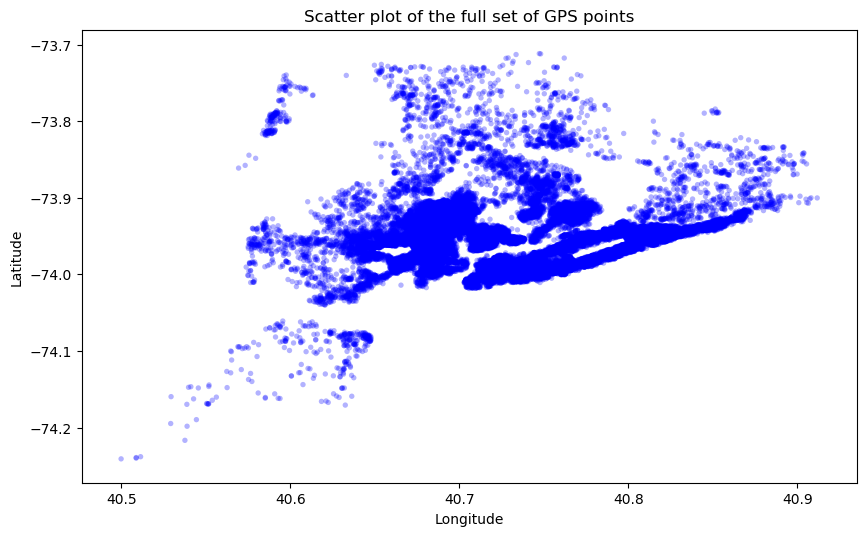

In [9]:
# convert the lat-long coordinates into a two-dimensional numpy array and plot it
coordinates = df_geo[['latitude', 'longitude']]

most_index = df_geo['neighborhood'].value_counts().head(5).index
most = pd.DataFrame(df_geo[df_geo['neighborhood'].isin(most_index)])
most.drop_duplicates(subset=['neighborhood'], keep='first', inplace=True)

plt.figure(figsize=(10, 6), dpi=100)
co_scatter = plt.scatter(coordinates['latitude'], coordinates['longitude'], c='b', edgecolor='', s=15, alpha=0.3)

plt.title('Scatter plot of the full set of GPS points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
N = len(coordinates) # N is the number of observations to group into k clusters

# Normalize the coordinate data with the whiten function
# Before running k-means, it is beneficial to rescale each feature dimension of the observation set with whitening.
# Each feature is divided by its standard deviation across all observations to give it unit variance.
w = whiten(coordinates)

k = 100 # k is the number of clusters to form

i = 50 # i is the number of iterations to perform

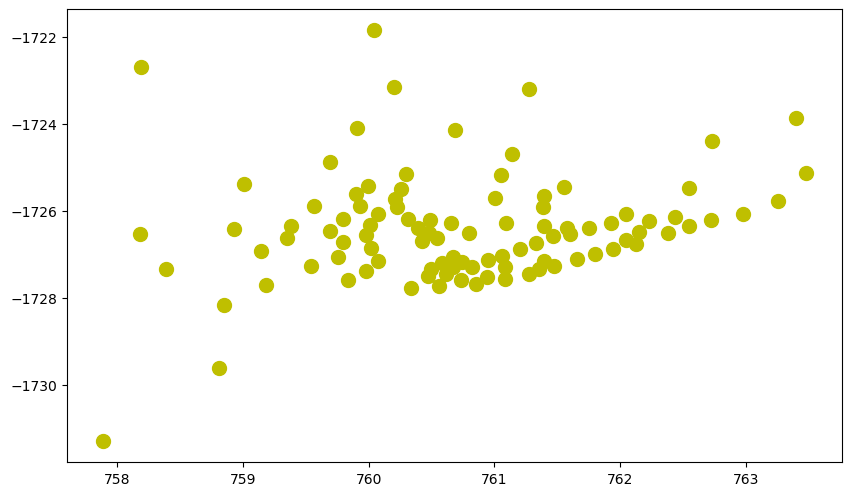

In [11]:
# Perform k-means on a set of observation vectors forming k clusters
# Return a codebook: centroid and last seen distortion(not the minimum)
cluster_centroids1, distortion = kmeans(w, k, iter=i)

# plot the cluster centroids
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(cluster_centroids1[:,0], cluster_centroids1[:,1], c='y', s=100)
plt.show()

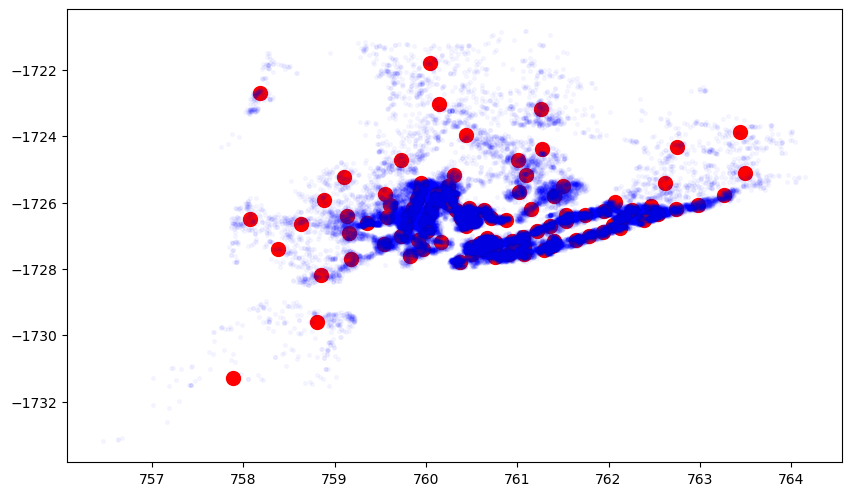

In [12]:
# The kmeans2 function classifies the set of observations into k clusters using the k-means algorithm
# it return a k by N array of centroids found at the last iteration of k-means,
# and an index of the centroid the i'th observation is closest to
# use optional argument minit='points' because the data is not evenly distributed
# minit='points' will choose k observations (rows) at random from data for the initial centroids
cluster_centroids2, closest_centroids = kmeans2(w, k, iter=i, minit='points')

# plot the cluster centroids
plt.figure(figsize=(10, 6), dpi=100)
# show centroids
plt.scatter(cluster_centroids2[:,0], cluster_centroids2[:,1], c='r', s=100)
# show observation from 2-dimensional matrix
plt.scatter(w[:,0], w[:,1], c='b', alpha=0.03, s=7)
plt.show()

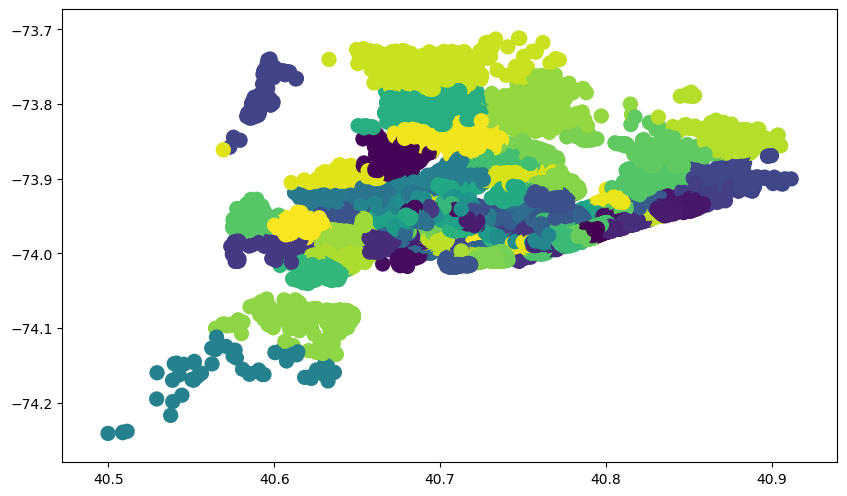

In [13]:
# plot the original full data set colored by cluster - not very useful with this many clusters
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(coordinates['latitude'], coordinates['longitude'], c=closest_centroids, s=100)
plt.show()

In [14]:
# Check-Box 
print('k =', k)
print('N =', N)

# the size of cluster_centroids1 and cluster_centroids2 should be the same as k
print(len(cluster_centroids1))
print(len(cluster_centroids2))

print(len(closest_centroids)) # the size of closest_centroids should be the same as N

print(len(np.unique(closest_centroids))) # the number of unique elements in closest_centroids should be the same as k

k = 100
N = 48486
100
100
48486
100


In [15]:
#### For each set of coordinates in our full data set, add the closest_centroid from the kmeans2 clustering
rs = pd.DataFrame(df_geo)
rs['closest_centroid'] = closest_centroids

# Reduce the data set so there is only one row for each closest_centroid
rs.drop_duplicates(subset=['closest_centroid'], keep='first', inplace=True)
rs.head()

,neighborhood,latitude,longitude,closest_centroid
0,BEDFORD STUYVESANT,40.685559,-73.940650,2
3,BEDFORD STUYVESANT,40.694073,-73.945514,51
4,OCEAN HILL,40.679685,-73.907642,44
5,CLINTON HILL,40.687762,-73.957620,37
6,BEDFORD STUYVESANT,40.693145,-73.942200,16


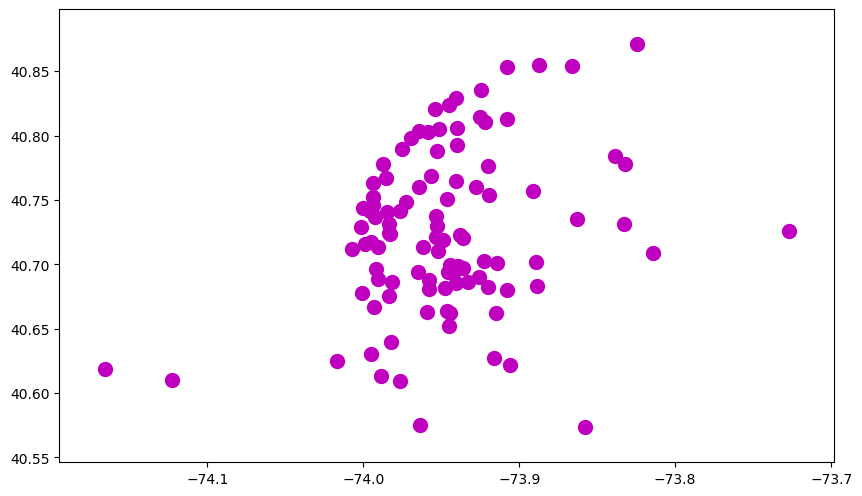

In [16]:
# Plot the final reduced set of coordinate points
plt.figure(figsize=(10, 6), dpi=100)
plt.scatter(rs['longitude'], rs['latitude'], c='m', s=100)
plt.show()

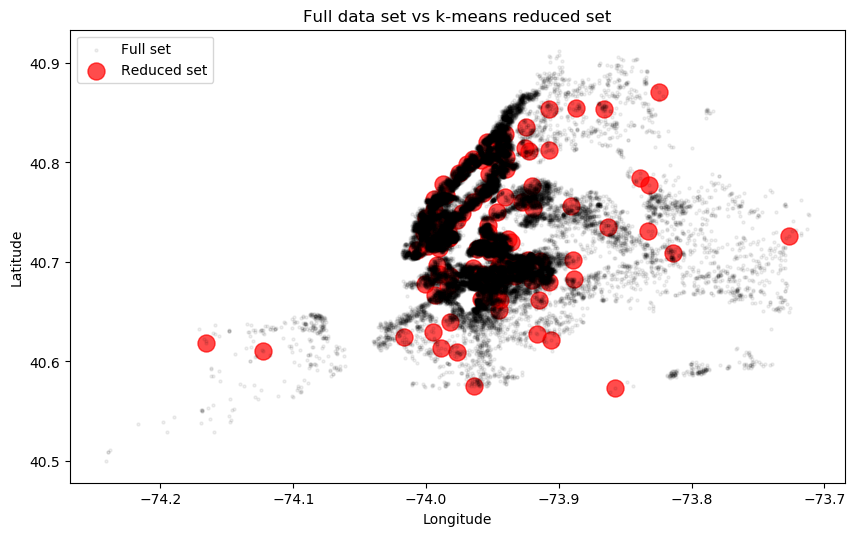

In [17]:
plt.figure(figsize=(10, 6), dpi=100)
rs_scatter = plt.scatter(rs['longitude'], rs['latitude'], c='r', alpha=.7, s=150)
df_scatter = plt.scatter(df_geo['longitude'], df_geo['latitude'], c='k', alpha=.06, s=5)

plt.title('Full data set vs k-means reduced set')
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

-----------------------------------
-----------------------------------